<a href="https://colab.research.google.com/github/RaymondLeong94/Flatiron_Capstone_Project-/blob/main/Final_Capstone_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Submission 3/3

- Program: Flatiron DS Flex 60 weeks

- Scheduled review date/time:

- Topic: Yelp NLP project 

- Name: Raymond Leong

- Instructor Name: Morgan Jones 
____________________________________________________________

# Introduction

# Business Problem

# Data Understanding 

### Loading in the data

In [1]:
#We will utilize Google collab and Google Drive
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
#change directory
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [3]:
#import necessary drives
import pandas as pd #our standard library to visualize. v1.5.3
import json #type of dataframe we're working with

For the reviews, the dataset is too large to load into Visual Studio Code or google collab. Thus the ideal solution is create a function that loads in data by going through a set amount of rows from the beginning of the json file. 

In [28]:
#the following function was from: 
#https://thedatafrog.com/en/articles/text-mining-pandas-yelp/
#author: colin
#publisher: The dataFrog
import matplotlib.pyplot as plt
pd.set_option('display.width', 10000)

#open the output file and set the encoding to utf 8
ifile = open('/content/gdrive/MyDrive/yelp_academic_dataset_review-001.json', encoding = 'utf-8', errors = 'ignore') 

#due to limitations in hardware, set stop to a # to deliver the amount of rows you want 
stop = 200000

#set a list

all_data = list()

#given the file name for yelp (ifile), this function will take each line by line,
#assign a unique index value for each line and store it as a list to all_data 
for i, line in enumerate(ifile):
#if i can be divided by 10,000- then a 10000 lines has been processed until the int for stop has occured 
    if i%10000==0:
        print(i)
    if i==stop:
        break    
    # convert the json on this line to a dict
    data = json.loads(line)
    # extract what we want
    text = data['text']
    stars = data['stars']
    user_id = data['user_id']
    business_id= data["business_id"]
    # add to the data collected so far
    all_data.append([stars, text, user_id, business_id])
# create the DataFrame
yelp_reviews = pd.DataFrame(all_data, columns=['stars','text', 'user_id', 'business_id'])


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


Load in Unique business: expand attributes and hours

In [ ]:
pd.set_option('mode.chained_assignment', None)
business = pd.read_json('/content/gdrive/MyDrive/yelp_academic_dataset_business.json', lines =True)
business_attributes = pd.json_normalize(business['attributes'])
business_hours = pd.json_normalize(business['hours'])


Combine the dataframes by dropping the attributes and hours column and remerging the df back together after attributes and hours gets normalized. Aditionally we would also expand the categories column and filter out the Philly restaurants

In [ ]:
#use result as a dummy for a consecutive conocating
result = pd.concat([business, business_attributes], axis=1,)

In [ ]:
#merge again
business = pd.concat([result, business_hours], axis =1)

In [ ]:
#this function drops the cateogries and split like a .explode function except it creates multiple row entries by expanding whenever  the str ","" is present. 
#reset index and rename it after adding it in
business_data = business.drop('categories', axis=1).join(business['categories'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('establishment_type'))

In [ ]:
#set this as type str for regex prep
business_data['establishment_type'] = business_data['establishment_type'].astype('str')


Regex is a library that helps us obtain the same word despite case sensitivity and some small errors. For instance Regex is necessary for the spacing in between ' and the first letter for some entries for restaurants ' Restaurants' and 'Restaurants' appear as seperate entries if not.

In [ ]:
#import re, find the data that only contains resturants and food with no case sensitivity
#restaurants and food are the type of establishments we are looking for
import re 
business_dataprep = business_data[business_data['establishment_type'].str.contains('.*Restaurants.*')| business_data['establishment_type'].str.contains('.*Food.*')]

In [ ]:
#get the city of Philadelphia only for our stakeholders
geo_example_philly= business_dataprep[business_dataprep['city'] == ("Philadelphia")]

In [ ]:
#this merges all of our restaurants
yelp_philly_merge= pd.merge(geo_example_philly, yelp_reviews, on='business_id', how ="left")

In [ ]:
#drop columns where there are no text
yelp_philly_merge =  yelp_philly_merge.dropna(subset = ['text'])

In [ ]:
#double check to see we have the columns
yelp_philly_merge.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars_x', 'review_count', 'is_open', 'attributes', 'hours', 'ByAppointmentOnly', 'BusinessAcceptsCreditCards', 'BikeParking', 'RestaurantsPriceRange2', 'CoatCheck', 'RestaurantsTakeOut', 'RestaurantsDelivery', 'Caters', 'WiFi', 'BusinessParking', 'WheelchairAccessible', 'HappyHour', 'OutdoorSeating', 'HasTV', 'RestaurantsReservations', 'DogsAllowed', 'Alcohol', 'GoodForKids', 'RestaurantsAttire', 'Ambience', 'RestaurantsTableService', 'RestaurantsGoodForGroups', 'DriveThru', 'NoiseLevel', 'GoodForMeal', 'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing', 'AcceptsInsurance', 'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage', 'HairSpecializesIn', 'Open24Hours', 'RestaurantsCounterService', 'AgesAllowed', 'DietaryRestrictions', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'establishment_type', 'stars_y', 'text', 'user_id'], dtype='object')

Stars x is the one of star of the restaurant by the overall majority
Stars y is the one of stars of the specific reviewer

In [ ]:
#we have 47123 entries
print(yelp_philly_merge.shape)

(37492, 63)


In [ ]:
#and they're all in philladelphia 
yelp_philly_merge[yelp_philly_merge['city'] == ("Philadelphia")].shape

(37492, 63)

# Data Preparation

### Fe 1: Time


##### We will find total hours and weekend hours

We create a variable for days and find out how many hours a restuarant is open for a week, and for the total weekend hours.

In [ ]:
#total hours (1)
#create columns for each day and fill na with 1:0 so they're never open
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
yelp_philly_merge[days] = yelp_philly_merge[days].fillna('1:0-1:0')

In [ ]:
# total hours (2)
# https://stackoverflow.com/questions/64125769/pandas-how-to-extract-and-calculate-the-number-of-hour-per-row-in-a-dataframe
# for this code to work we needed to get rid of the overnight and 24 hour opening
def calculate_hours(row: pd.Series) -> float:
    """
    This code seperates the open hours and minutes from the closed
    Then it seperates the open hours from the open minutes (same for closed)
    Then it calculates a variable called a start time and addd the hour to the minute/60.
    The result is a float that can be used to determine how long the restaurant was opened.
    The result is total hours
    """
    
    try:
        # split the given times to start and end time
        opening_time, closing_time = row.split("-")
        # split hours and minutes
        start_hour, start_minute = opening_time.split(":")
        end_hour, end_minute = closing_time.split(":")
        # calculate start time (in hours)
        start_time = float(start_hour) + float(start_minute) / 60
        # calculate end time (in hours)
        end_time = float(end_hour) + float(end_minute) / 60
        # handle overneight and 24h openings
        if start_time >= end_time:
            end_time += 24
        # return the duration from start time to end time
        return end_time - start_time
    # bare except are not recommended, you should look for your data, what could go wrong
    except:
        return 0.0
   
         


# Save the given data to the new column "open"
# sums up values for each day

days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
#return the sum of the hours for the week
yelp_philly_merge["total_hours"] = sum([yelp_philly_merge[day].apply(calculate_hours) for day in days])

In [ ]:
#Weekend hours can be obtained by adding all of the fri sat and sun
yelp_philly_merge["weekend_hours"]=  yelp_philly_merge["Friday"].apply(calculate_hours) +\
             yelp_philly_merge["Saturday"].apply(calculate_hours) +\
             yelp_philly_merge["Sunday"].apply(calculate_hours)

In [ ]:
#reconvert to float
yelp_philly_merge["weekend_hours"] = yelp_philly_merge["weekend_hours"].astype(float)
yelp_philly_merge["total_hours"] = yelp_philly_merge["total_hours"].astype(float)

Text(0, 0.5, 'Density of hours')

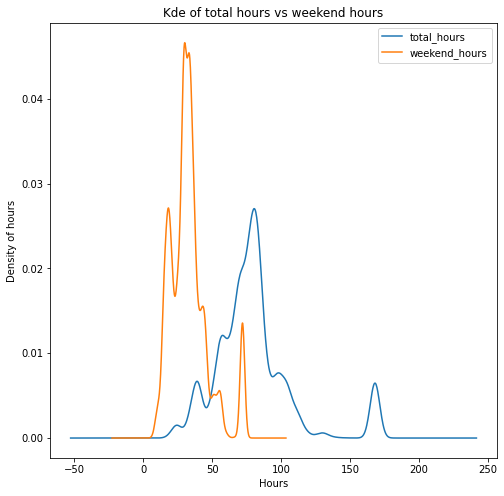

In [ ]:
#this is a great graph to compare 
yelp_philly_merge.plot(kind ='kde', x='stars_x', y=['total_hours', 'weekend_hours',], figsize= (8,8), grid = False)
plt.title("Kde of total hours vs weekend hours")
plt.xlabel("Hours")
plt.ylabel("Density of hours")


This shows us that there is a large amount of restaurants opened from 0-50 hours on weekends.The same restaurants are usually open from 25-100 hours every week

We now want to see if theres a linear correlation between hours and stars. We import sklearn (v1.2.1) is great for machine learning. In this ML we simply want to see if theres a linear correlation between hours and stars. We will have two models, one based on weekend hours and one based on total hours. We use stats mod (sm) as part our OLS model (also from sm), in order to have a constant for our Ordinary least squares, which minimizes the sum of squared errors. 

This important to our stake holder because we want to find trends because the squared errors represent have far we are deviating from a linear relationship. Thus restaurant's hours may have 0 contribution to the amount of stars, this means that the employees can have more flexibility for their hours.

In [ ]:
#simple OLS model to see if theres any linear correlation 

from scipy import stats
from sklearn.linear_model import LinearRegression #linear regression for a linear relationship
import sklearn.metrics as metrics #metrics
import statsmodels.api as sm #stats constant
from statsmodels.formula.api import ols
Y = yelp_philly_merge['stars_x']
X = yelp_philly_merge["weekend_hours"]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                stars_x   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     3258.
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:43:04   Log-Likelihood:                -30690.
No. Observations:               37492   AIC:                         6.138e+04
Df Residuals:                   37490   BIC:                         6.140e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.2125      0.007    567.558

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
Y= None
X= None
vif= None 
Y = yelp_philly_merge['stars_x']
X = yelp_philly_merge["total_hours"]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                stars_x   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     3199.
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:43:04   Log-Likelihood:                -30717.
No. Observations:               37492   AIC:                         6.144e+04
Df Residuals:                   37490   BIC:                         6.145e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2660      0.008    510.078      

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


From the results of these two models we can state that there is no linear relationship between the hours and restaurant's performance.

In [ ]:
yelp_philly_merge

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,Thursday,Friday,Saturday,Sunday,establishment_type,stars_y,text,user_id,total_hours,weekend_hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,4.0,This is nice little Chinese bakery in the hear...,6_SpY41LIHZuIaiDs5FMKA,94.0,42.0
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,4.0,This is the bakery I usually go to in Chinatow...,tCXElwhzekJEH6QJe3xs7Q,94.0,42.0
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,5.0,"A delightful find in Chinatown! Very clean, an...",WqfKtI-aGMmvbA9pPUxNQQ,94.0,42.0
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,5.0,I ordered a graduation cake for my niece and i...,3-1va0IQfK-9tUMzfHWfTA,94.0,42.0
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,4.0,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,EouCKoDfzaVG0klEgdDvCQ,94.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37669,TCROPjxfzCZzrQjqLqstSg,Red Cup Cafe & Hookah Lounge,400 Fairmount Ave,Philadelphia,PA,19123,39.962577,-75.144748,4.0,53,...,19:0-2:0,19:0-2:0,19:0-2:0,1:0-1:0,Restaurants,5.0,Red cup cafe is a great little place in Northe...,jPeHf-2XAhkU7ZHZksM24A,117.0,38.0
37670,TCROPjxfzCZzrQjqLqstSg,Red Cup Cafe & Hookah Lounge,400 Fairmount Ave,Philadelphia,PA,19123,39.962577,-75.144748,4.0,53,...,19:0-2:0,19:0-2:0,19:0-2:0,1:0-1:0,Restaurants,3.0,Red Cup Cafe is a unpretentious space in North...,2xWGCfc2GeTEaspPPPKSOA,117.0,38.0
37671,TCROPjxfzCZzrQjqLqstSg,Red Cup Cafe & Hookah Lounge,400 Fairmount Ave,Philadelphia,PA,19123,39.962577,-75.144748,4.0,53,...,19:0-2:0,19:0-2:0,19:0-2:0,1:0-1:0,Restaurants,2.0,Has gone downhill since Rick left. I think it'...,kGI_0MewcCmkpLMOX2MjYw,117.0,38.0
37672,TCROPjxfzCZzrQjqLqstSg,Red Cup Cafe & Hookah Lounge,400 Fairmount Ave,Philadelphia,PA,19123,39.962577,-75.144748,4.0,53,...,19:0-2:0,19:0-2:0,19:0-2:0,1:0-1:0,Restaurants,4.0,Katie I's review is spot on... \n\nAnother thi...,Ob5S_YT0mszh5CkWbzGRBA,117.0,38.0


###Fe 2: Distance

##### Cleaning the data for Longitude and latitude for geopy

The point of this is to calculate the average distance of the lowest star to the current star. This is important to our stakeholders, because they might not want to be next to a 1 or 2 star restaurant.

######Obtaining average longitude and latitude for philly restaurants and creating a dictionary

In [ ]:
#get the mean for longitude 
avg_longitude = yelp_philly_merge.groupby('stars_x')['longitude'].mean()
#long
avg_latitude= yelp_philly_merge.groupby('stars_y')['latitude'].mean()
#get it to the frame
avg_latitude= avg_latitude.to_frame(name='lat')
#always reset index
avg_latitude=avg_latitude.reset_index()
#rename one of them into stars 
avg_latitude['stars'] = avg_latitude['stars_y']
#repeat for long
avg_longitude = avg_longitude.to_frame(name='long')
avg_longitude=avg_longitude.reset_index()
avg_longitude['stars'] = avg_longitude['stars_x']


In [ ]:
#merge avg long and lat on stars
long_lat = pd.merge(avg_latitude, avg_longitude, on = "stars")

In [ ]:
#drop original cols
long_lat= long_lat.drop(columns= ['stars_y', 'stars_x'])
star_location = long_lat.set_index('stars').to_dict()
star_location

{'lat': {1.0: 39.964996363797646,
  2.0: 39.96068879372368,
  3.0: 39.96033042999306,
  4.0: 39.959762327539934,
  5.0: 39.96291676144239},
 'long': {1.0: -75.10726831091667,
  2.0: -75.1556673012782,
  3.0: -75.17384039924832,
  4.0: -75.15930731866293,
  5.0: -75.14304635116446}}

Using Geopy for converting longitude and latitude coordinates to distances in our preferred units.
Official documentation here: https://geopy.readthedocs.io/en/stable/


In [ ]:
#we need a function where we find the distance closeset to the first star (lowest)
from geopy.distance import distance
 
def calculate_distance(row):
    """ 
    This calculates the distance between the current dataframe's row's long and lat 
    by looking at the stars in the dataframe
    and then comparing it to the first entry and calculating the distance
    """
    
    star = row['stars_y']
    lat1, long1 = row[['latitude', 'longitude']]
    lat2, long2 = star_location['lat'][stars], star_location['long'][stars]
    return distance((lat1, long1), (lat2, long2)).m

yelp_philly_merge['distance_to_lowest_star'] = yelp_philly_merge.apply(calculate_distance, axis=1)

<AxesSubplot:xlabel='stars_x'>

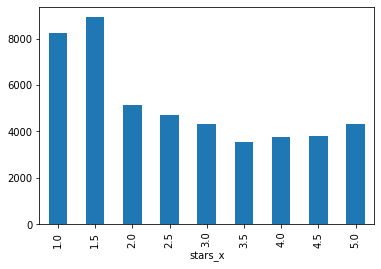

In [ ]:
 #group data by stars_x and display distance as mean 
 #https://www.statology.org/pandas-groupby-plot/
 yelp_philly_merge.groupby('stars_x')['distance_to_lowest_star'].mean().plot(kind = 'bar')


From this graph we can see that as you go up in stars the distance decreases (until you hit 3.5 stars) and then increases as stars goes up. More modeling is needed to examine the relationship

 ### Fe Entity Extraction (Cleaning)

In [ ]:
yelp_philly_merge['text'] = yelp_philly_merge.text.astype(str)

Similar to notebook 2, we want to use the following justification for adjustments made due to the food industry. 

We modify the stopwords this time to include food that are ethnic (we can't tell if the food is good or not) and get rid of some common words such as food and cuisine. What we want to see is a display of words that tell us about the waiter or the quality that needs to be improved on. The ethnicity of the food should be generalized thus stopwords include american, greek, chinese etc. Additionally some words such as dont, u and nice appear most common words and we should elimiate filter words that do not contribute to the reviews contents

In [ ]:
#https://github.com/sharmaroshan/Twitter-Sentiment-Analysis/blob/master/LICENSE
#under license provided, this code was supplied by the NLTK library and github owner above
#adjustments made by me are highlighted. 
import nltk
nltk.download('punkt')#library of words
nltk.download('words')#another library of words
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import re
import nltk
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer #three different type of tokenizers that we may use 
from nltk.corpus import stopwords, wordnet# need
from nltk.stem import WordNetLemmatizer #need
sw = stopwords.words('english')

#what other stop wards can be used to that is not representative
sw.extend(['link', 'rt', 
'food', 'review', 'yummy', 'cusine', 'dishes', 'tasty', 'delicious'
'tacos', 'burritos', 'sushi', 'american', 'greek', 'chinese', 'pizza' 'really', 'always', 'rarely' 'ive', 'dont', 'u', 'nice'])
#added all punctuation, made sure # and @ wasnt in there
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!'
twitter_re = re.compile('[#@][a-zA-Z]*')
num_re = re.compile('^\d{1}$')
hashtags = re.compile ("#([a-zA-Z0-9_]{1,50})")

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def txt_clean(txt, stop_words=sw):
    # takes in a string and returns a cleaned up string ready for count or tfidf vectorizing
    
    # splitting the text up into words
    t = txt.split(' ')
    # turning the words lowercase
    t = [w.lower() for w in t]
    # removing punctuation
    t = [w.translate(w.maketrans('','', punctuation)) for w in t]
    # removing @'s and #'s which are twitter jargon
    t = [w for w in t if not twitter_re.match(w)]
    t = [w for w in t if not hashtags.match(w)]

    # removing leftover numbers
    t = [w for w in t if not num_re.match(w)]
    # removing stop words and more twitter jargon
    t = [w for w in t if w not in stop_words]
    # removing empty strings
    t = [w for w in t if w]
    
    # word lemmatizing
    t = pos_tag(t)
    t = [(w[0], get_wordnet_pos(w[1])) for w in t]
    lem = WordNetLemmatizer()
    t = [lem.lemmatize(w[0], w[1]) for w in t]
    # joining all the strings together into one
    return ' '.join(t)
yelp_philly_merge['text_refurbished'] = yelp_philly_merge["text"].map(txt_clean)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### FE Entity Extraction

NLTk has the following modules and referenced here: https://www.nltk.org/howto/chunk.html

Here we will find the entities by passing the reurbished text some NLTK modules

1. Pos_tag tags each word as an adjective, noun, etc as its own form and is needed because the output is how we extract the nouns and verbs and adjectives 

2. Punkt is a tokenizer that will first break up words and create tokens (each string is a comma seperated value filled with strings)

3. We use chunking to put together words that describe the full context of the entity. This is extremely important as we will filter out words that are not of the topic of discussion for the review.

In [ ]:
yelp_philly_merge['text_refurbished']= yelp_philly_merge['text_refurbished'].astype(str)

In [ ]:
import nltk
import pandas as pd
nltk.download('punkt') # our tokenizer that breaks up words based on the entities 
nltk.download('maxent_ne_chunker')
nltk.download('words') #necessary for chunker
from nltk import word_tokenize, pos_tag, ne_chunk
yelp_philly_merge['entities'] = yelp_philly_merge['text_refurbished'].apply(lambda x: ne_chunk(pos_tag(word_tokenize(x))))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Lets obtain the nouns, adjectives and verbs 

In [ ]:

def extract_nouns(text):
    """
    This function takes all the nouns out of the entities recognized
    """
    # Tokenize the text data into words
    tokens = word_tokenize(text)

    # Tag the parts of speech in the text
    tagged = pos_tag(tokens)

    # Filter the tagged words to only include the nouns
    filtered_nouns = [word for word, pos in tagged if pos == "NN"]

    # Return the filtered nouns
    return filtered_nouns

# Apply the extract_nouns function to each row in the text_column
yelp_philly_merge['extract_nouns'] = yelp_philly_merge['text_refurbished'].apply(extract_nouns)


Now all the adjectives 

In [ ]:

def extract_jj(text):
    # Tokenize the text data into words
    tokens = word_tokenize(text)

    # Tag the parts of speech in the text
    tagged = pos_tag(tokens)

    # Filter the tagged words to only include the nouns
    filtered_nouns = [word for word, pos in tagged if pos == "JJ"]

    # Return the filtered nouns
    return filtered_nouns

# Apply the extract_nouns function to each row in the text_column
yelp_philly_merge['extract_adjectives'] = yelp_philly_merge['text_refurbished'].apply(extract_jj)



Finally all the verbs 

In [ ]:

def extract_verbs(text):
    # Tokenize the text data into words
    tokens = word_tokenize(text)

    # Tag the parts of speech in the text
    tagged = pos_tag(tokens)

    # Filter the tagged words to only include the nouns
    filtered_nouns = [word for word, pos in tagged if pos == "VB"]

    # Return the filtered nouns
    return filtered_nouns

# Apply the extract_nouns function to each row in the text_column
yelp_philly_merge['extract_verbs'] = yelp_philly_merge['text_refurbished'].apply(extract_verbs)



In [ ]:
from google.colab import files
yelp_philly_merge.to_csv('cleaned_merge.csv', encoding = 'utf-8') 
files.download('cleaned_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
yelp_philly_merge = pd.read_csv('cleaned_merge.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
#ecombine each into one column but we're not using verbs
yelp_philly_merge['nouns_adjec']= yelp_philly_merge['extract_nouns'].astype(str) + yelp_philly_merge['extract_adjectives'].astype(str)

In [15]:
#replace the elements so that the tokenizer can do its job
yelp_philly_merge['nouns_adjec'] = yelp_philly_merge['nouns_adjec'].apply(lambda x: x.replace('[', ''))
yelp_philly_merge['nouns_adjec'] = yelp_philly_merge['nouns_adjec'].apply(lambda x: x.replace(']', ''))
yelp_philly_merge['nouns_adjec'] = yelp_philly_merge['nouns_adjec'].apply(lambda x: x.replace(',', ''))
yelp_philly_merge['nouns_adjec'] =yelp_philly_merge['nouns_adjec'].apply(lambda x: x.replace(", '", "'"))
yelp_philly_merge['nouns_adjec'] =yelp_philly_merge['nouns_adjec'].apply(lambda x: x.replace("'", ""))

In [16]:

yelp_philly_merge['nouns_adjec'][0]

'heart philadelphia female cashier pastry show display case evening sesame ball paste rice ball bai tang gao arealittle bakery chinatown flirtatious adorn fill bean glutinous similar place worth'

In [ ]:
yelp_philly_merge['nouns_adjec_verbs']=yelp_philly_merge['nouns_adjec_verbs'].astype(str).apply(lambda x: x.replace(", ", ","))
yelp_philly_merge['nouns_adjec_verbs']=yelp_philly_merge['nouns_adjec_verbs'].astype(str).apply(lambda x: x.replace("''", "'"))

In [ ]:
#replace the first entry 
yelp_philly_merge['nouns_adjec_verbs']= yelp_philly_merge['nouns_adjec_verbs'].astype(str).apply(lambda x: ' ' + x[1:] if x else '')

In [18]:
yelp_philly_merge['nouns_adjec']

0        heart philadelphia female cashier pastry show ...
1        bakery variety bun pastry bun mung coconut stu...
2        kind service everyone treat treat judgement th...
3        order graduation event staffniece perfect come...
4        milk saint honore pastry business boyfriend ti...
                               ...                        
37487    cup place liberty rick owner coffee egg bacon ...
37488    cup space liberty art build cozy stop time mor...
37489                          downhill rick managementnew
37490    katie spot thing note place hafta morning batt...
37491    day wow chocolate pie havent try coffee latted...
Name: nouns_adjec, Length: 37492, dtype: object

# EDA Modeling of NLP results through Count Vecotrization and Word 2 vec

### Model using CV 

NameError: ignored

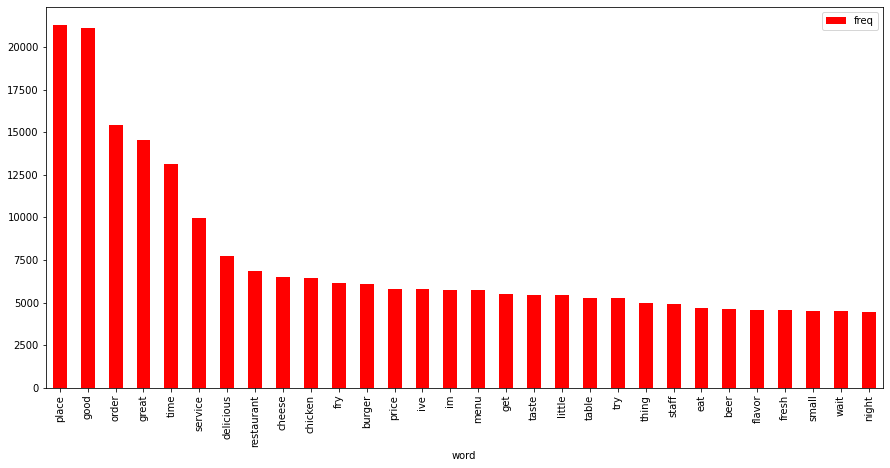

In [19]:
#CV for most common extracted nouns adjectives and verbs
#obtained and adjusted from flatiron
from sklearn.feature_extraction.text import CountVectorizer
#set X to encompass all tweet_text 
X = yelp_philly_merge['nouns_adjec']


#use the CV classifier to pass the column without a tokenizer, preprocessor and set lowercase=False 
cv = CountVectorizer(tokenizer=None,
                             preprocessor=None,
                             lowercase=False)
#creates a sparse matrix
words = cv.fit_transform(X)
#add all the values into a variable called sum_words
sum_words = words.sum(axis=0)

#for every word in cv.vocabulary.items (which returns a list), add it to the unique count
#gives off a list of tuples' (item',count) that resembles a pd
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
#sort by ascending order
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
#create the df
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
#use iloc next time
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'red')
plt.xlabel("Word")
plt.ylabel("Counts of Word", labelpad=14)
plt.title("Word analysis through Count Vectorization", y=1.02)


Order shows up here along with specific types of food such as fries, chicken and cheese. Portion size is referred to as small often


##### Word clouds for nouns, adjectives and verbs

In [ ]:
#mandatory adjustments
yelp_philly_merge['extract_nouns']= yelp_philly_merge['extract_nouns'].astype(str)
yelp_philly_merge['extract_nouns'] = yelp_philly_merge['extract_nouns'].str.strip('[]')

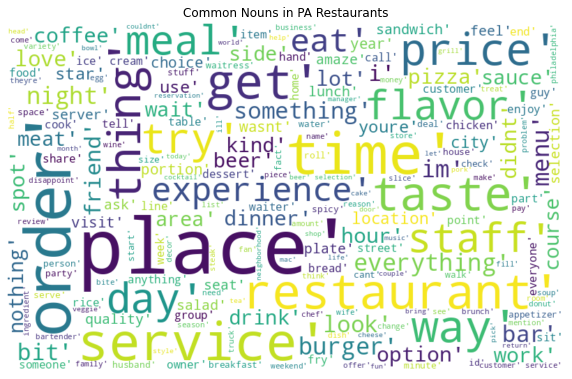

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from wordcloud import WordCloud
nouns =' '.join([text for text in yelp_philly_merge['extract_nouns']])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(nouns)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Common Nouns in PA Restaurants')
plt.show()


It would be advisible to price our menu appropriately, service occurs very often in the nouns along with flavor

In [ ]:
#mandatory adjustments
yelp_philly_merge['extract_adjectives']= yelp_philly_merge['extract_adjectives'].astype(str)
yelp_philly_merge['extract_adjectives'] = yelp_philly_merge['extract_adjectives'].str.strip('[]')

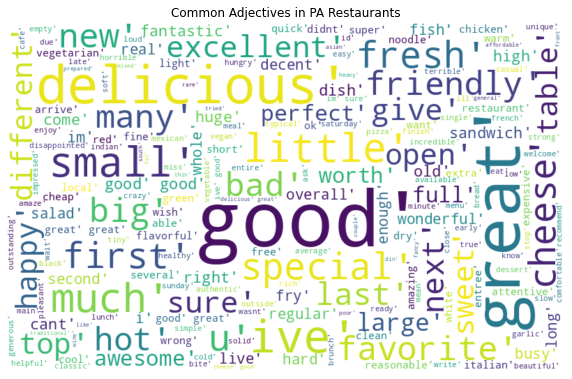

In [ ]:
#for adjectives
adjectives =' '.join([text for text in yelp_philly_merge['extract_adjectives']])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(adjectives)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Common Adjectives in PA Restaurants')
plt.show()


In [ ]:
#mandatory adjustments
yelp_philly_merge['extract_verbs']= yelp_philly_merge['extract_verbs'].astype(str)
yelp_philly_merge['extract_verbs'] = yelp_philly_merge['extract_verbs'].str.strip('[]')

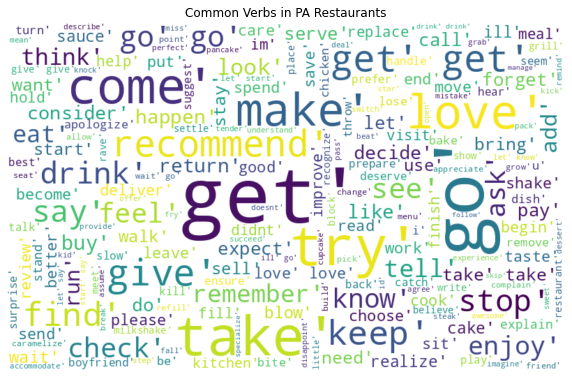

In [ ]:
#for adjectives
verbs=' '.join([text for text in yelp_philly_merge['extract_verbs']])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(verbs)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Common Verbs in PA Restaurants')
plt.show()


At this point only the nouns bring some recommendations and the adjectives and verbs do not show much information that we can make recommendations off of.

Word to vec documentation: https://www.tensorflow.org/tutorials/text/word2vec

Now we are going to use our word2vec from gensim model which is a library that looks for semantic similarity (association between words)

In [22]:
from gensim.models import Word2Vec
from nltk import word_tokenize

Tokenizing (more cleaning)

In [23]:
corpus =  yelp_philly_merge['nouns_adjec'].map(word_tokenize)

In [24]:
corpus

0        [heart, philadelphia, female, cashier, pastry,...
1        [bakery, variety, bun, pastry, bun, mung, coco...
2        [kind, service, everyone, treat, treat, judgem...
3        [order, graduation, event, staffniece, perfect...
4        [milk, saint, honore, pastry, business, boyfri...
                               ...                        
37487    [cup, place, liberty, rick, owner, coffee, egg...
37488    [cup, space, liberty, art, build, cozy, stop, ...
37489                      [downhill, rick, managementnew]
37490    [katie, spot, thing, note, place, hafta, morni...
37491    [day, wow, chocolate, pie, havent, try, coffee...
Name: nouns_adjec, Length: 37492, dtype: object

### Word to Vec 

In [25]:
#min count = 1 for freq 
#vectorsize = 100 
#windows = amount it will go left and right 
model = Word2Vec(corpus, size=300, min_count = 1, window = 10)

In [ ]:
vocabulary = model.wv.vocab


<ipython-input-29-3f644ebd6c4a>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  list_model_manager= model.most_similar('waiter')


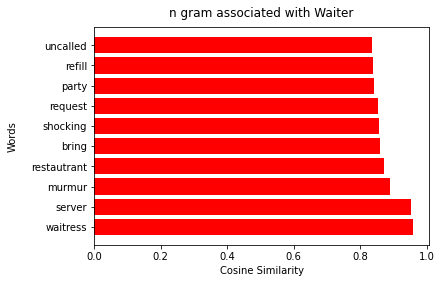

In [29]:
#look at the unigram most similar to waitress
list_model_manager= model.most_similar('waiter')
list_model_manager
word = []
frequency = []

for i in range(len(list_model_manager)):
  word.append(list_model_manager[i][0])
  frequency.append(list_model_manager[i][1])


plt.barh(word, frequency, color='r')

plt.xlabel("Cosine Similarity")
plt.ylabel("Words", labelpad=14)
plt.title("n gram associated with Waiter", y=1.02)
plt.show()


<ipython-input-30-7cad6c084fbe>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  list_model_manager= model.most_similar('waiteress')


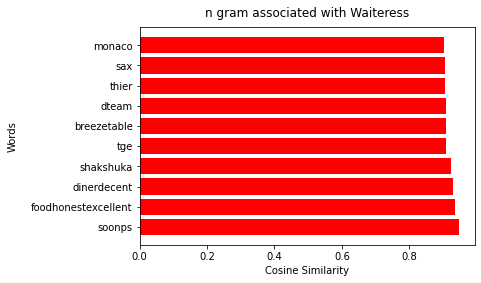

In [30]:
#look at the unigram most similar to waitress
list_model_manager= model.most_similar('waiteress')
list_model_manager
word = []
frequency = []

for i in range(len(list_model_manager)):
  word.append(list_model_manager[i][0])
  frequency.append(list_model_manager[i][1])


plt.barh(word, frequency, color='r')

plt.xlabel("Cosine Similarity")
plt.ylabel("Words", labelpad=14)
plt.title("n gram associated with Waiteress", y=1.02)
plt.show()


<ipython-input-31-437f84a37ca0>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  list_model_manager= model.most_similar('food')


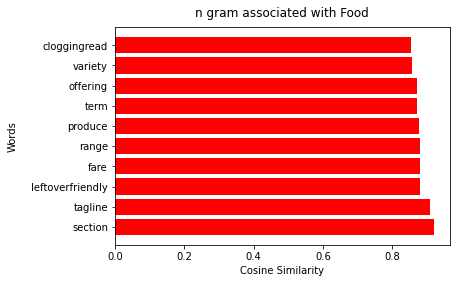

In [31]:
#look at the unigram most similar to waitress
list_model_manager= model.most_similar('food')
list_model_manager
word = []
frequency = []

for i in range(len(list_model_manager)):
  word.append(list_model_manager[i][0])
  frequency.append(list_model_manager[i][1])


plt.barh(word, frequency, color='r')

plt.xlabel("Cosine Similarity")
plt.ylabel("Words", labelpad=14)
plt.title("n gram associated with Food", y=1.02)
plt.show()


<ipython-input-32-40283b67b93e>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  list_model_manager= model.most_similar('texture')


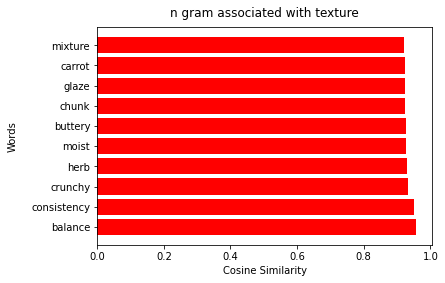

In [32]:
#look at the unigram most similar to waitress
list_model_manager= model.most_similar('texture')
list_model_manager
word = []
frequency = []

for i in range(len(list_model_manager)):
  word.append(list_model_manager[i][0])
  frequency.append(list_model_manager[i][1])


plt.barh(word, frequency, color='r')

plt.xlabel("Cosine Similarity")
plt.ylabel("Words", labelpad=14)
plt.title("n gram associated with texture", y=1.02)
plt.show()


In [33]:
#phrases will allow us to analyze words in pairs 
from gensim.models import Phrases

# Train a bigram detector.
bigram_transformer = Phrases(corpus)

# Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.
bi_gram_model = Word2Vec(bigram_transformer[corpus], min_count=1)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Bigram for service 

<ipython-input-34-1f674ec7c4ef>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  list_model_manager= bi_gram_model.most_similar('waiteress')


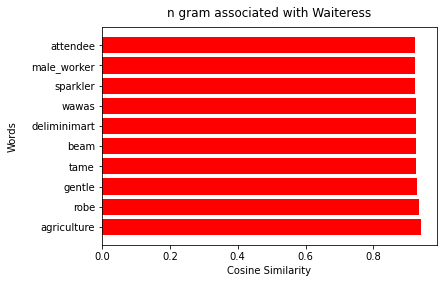

In [34]:
#look at the bigram most similar to waiter
list_model_manager= bi_gram_model.most_similar('waiteress')
list_model_manager
word = []
frequency = []

for i in range(len(list_model_manager)):
  word.append(list_model_manager[i][0])
  frequency.append(list_model_manager[i][1])


plt.barh(word, frequency, color='r')

plt.xlabel("Cosine Similarity")
plt.ylabel("Words", labelpad=14)
plt.title("n gram associated with Waiteress", y=1.02)
plt.show()


# Modeling

Since MNB and RF have already been used, let us try using keras to create a word embedding layer and establish the accuracy of the previous model (word vec)

In [38]:
#idea from https://www.youtube.com/watch?v=Fuw0wv3X-0o
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot #this one hots the sequence with tensor
from tensorflow.keras.preprocessing.sequence import pad_sequences #matches arrays to make 0s post or pre
from tensorflow.keras.models import Sequential #layer of network models
from tensorflow.keras.layers import Dense #our specific one
from tensorflow.keras.layers import Flatten #output layer
from tensorflow.keras.layers import Embedding #embedding layer

In [42]:
for_keras= yelp_philly_merge['nouns_adjec'].values

In [43]:
#vocab size, one hot for keras 
vocab_size = 300
encoded_reviews = [one_hot(x, vocab_size) for x in for_keras]
print(encoded_reviews)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [44]:
#max length of array
max_length = 10
padded_reviews = pad_sequences(encoded_reviews, maxlen=max_length, padding='post')
print(padded_reviews)

[[197 101 248 ...  45  82  21]
 [174  62 122 ... 146 135  81]
 [254  29  58 ... 122 110 279]
 ...
 [ 21 185  92 ...   0   0   0]
 [246  30  24 ... 234  22 116]
 [253  45 229 ... 122  48  21]]


In [45]:
#how many vectors we want for the word (dimensions)\
#this model will take the embedding layer first with the variables and their parameters inputted
embeded_vector_size = 5
model = Sequential()
model.add(Embedding(vocab_size, embeded_vector_size, input_length=max_length, name = "embedding")) 
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) # activate sigmoid so that its 0 or 1, as in our output created below

In [47]:
#this function transforms our output variable to 0 or 1, with 1 being the higher rated restaurants
def stars_transform(x):
  if x >= 3.5:
    return 1
  else:
    return 0 
yelp_philly_merge['stars_x'] = yelp_philly_merge['stars_x'].apply(stars_transform)

In [49]:
yelp_philly_merge['stars_x'].value_counts()

1    32789
0     4703
Name: stars_x, dtype: int64

In [50]:
sentiment = yelp_philly_merge['stars_x'].values.flatten()

In [51]:
X = padded_reviews
y=sentiment

In [52]:
#using adam as our standard gradient descent 
#loss is binarycross entropy because its between true and predicted classes (roc_auc)
#we use accuracy this time for our final metric
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 5)             1500      
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 1,551
Trainable params: 1,551
Non-trainable params: 0
_________________________________________________________________


In [53]:
#fit
#epoch is the number of times the algorithim will work through the whole set
#verbose is just telling us the progress of epochs
model.fit(X, y, epochs=50, verbose=0)

In [54]:
loss, accuracy = model.evaluate(X,y)
accuracy

1172/1172 [==============================] - 6s 5ms/step - loss: 0.3147 - accuracy: 0.8813


0.881281316280365